In [ ]:
#  import main packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import pyarrow 

# define variables
file_version = ".1"
immo_vis_dir = "../../data/immo_vis/"
parquet_extension = ".parquet"
metropole_appartement_file = "ventes-metropole-appartement" + file_version  + parquet_extension
metropole_maison_file = "ventes-metropole-maison" +  file_version + parquet_extension
metropole_appartement_file_cleaned = metropole_appartement_file + "_step1_clean_" + parquet_extension

dpe_ranking     = ['0','A','B','C','D','E','F','F/G','G','NS','Unknown']
dpe_ranking_num = [0,1,2,3,4,5,6,7,7,0,0]

#  Set plot options
LargePlotActive = False
MediumPlotActive = False
SmallPlotActive = False
HeatMapDisplay = False

# chauffage système
chauffage_sys =["chauf_sys_climatisation","chauf_sys_radiateur","chauf_sys_pompe-chaleur","chauf_sys_chaudiere","chauf_sys_convecteur","chauf_sys_sol","chauf_sys_poele-bois"]
chauffage_mode =["chauffage_mode_individuel","chauffage_mode_collectif","chauffage_mode_central"]
chauffage_energie =["chauf_fioul","chauf_elec","chauf_gaz","chauf_bois"]
chauffage_systems = chauffage_sys + chauffage_mode + chauffage_energie

# expositions
expositions =['expo_has_nord', 'expo_has_sud', 'expo_has_est', 'expo_has_ouest']


# # functions

In [ ]:
# functions  

def print_numerical_isna(df) :
    columns = df.select_dtypes(include='number').columns.tolist()
    print (df[columns].isna().sum())

def print_categorial_isna(df) :
    columns = df.select_dtypes(include='category').columns.tolist()
    print (df[columns].isna().sum())     

def load_appartement_file () :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file
    return pd.read_parquet(final_path.as_posix())

def save_appartement_file (df) :
    start_path = Path(immo_vis_dir)
    final_path = start_path / metropole_appartement_file_cleaned
    final_path.as_posix
    df.to_parquet(path=final_path.as_posix(),index=True)

def get_numerical_column_names (df) :
    return [ column for column  in df.columns if df[column].dtype not in ["object","category"]]


In [ ]:
# chauffage système
def display_heatmap(df, data_selection,target="prix_m2_vente",size=8,annotation=True) : 
    plt.figure(figsize=[size,size])

    data_selection.append(target)
    param = {
        'vmax': 1, 
        'vmin': -1, 
        'cmap': 'coolwarm', 
        'annot': annotation,
        'square': True,           # Cellules carrées
        'fmt': '.2f',            # Format des nombres (3 décimales)
        'cbar_kws': {'label': 'Corrélation'}  # Label de la colorbar
    }
    data = df.loc[:,data_selection].corr()
    display(data[target])
    sns.heatmap(data=data,**param)

# # decode file and display infos

In [ ]:
# import appartement file

start_path = Path(immo_vis_dir)
final_path = start_path / metropole_appartement_file
df = load_appartement_file()
nb_rows= df.shape[0]
nb_cols= df.shape[1]

In [ ]:
#  print main infos on appartmeent file


print ( f" {metropole_appartement_file} rows {nb_rows} columns {nb_cols}")
print (df.shape)
print (df.columns)
print (df.info())
print (df.describe())



In [ ]:
#  print columns modalities
for i in df.columns:
    print(f'modalities  {i} are : ',(df[i].nunique()))

In [ ]:
#  print comlmns nan values
for i in df.columns:
    print(f' {i} nan values {df[i].isna().sum()}  {(100*df[i].isna().sum()/len(df)):.2f}%')

#  process type_de_bien

In [ ]:
#  modify logement_neuf nan according to type de bien

df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "an", df['logement_neuf'].fillna('o'))
df['logement_neuf'] = df['logement_neuf'].where(df['typedebien'] == "a", df['logement_neuf'].fillna('n'))

print (df["logement_neuf"].isna().sum())

# replace an by a
df.loc[:,'typedebien'] ="a"

# process logement neuf as integer
df['logement_neuf'] = df['logement_neuf'].replace(['o','n'],[1,0])

print (df.typedebien.value_counts())
print (df.logement_neuf.value_counts())

print ("************** type de bien ***************************")
print ("keep only type de bien = a , logement neuf as integer 0 1")

## Drop columns that are not relevant

In [ ]:
#rendre index=idannonce pour retrouver la ligne initiale
df.set_index('idannonce',drop=True,inplace=True)

#supprimer les colonnes non pertinentes pour les maisons
df.drop(columns=['type_annonceur', 'typedetransaction','typedebien_lite',
       'prix_maison', 'prix_terrain', 'mensualiteFinance',"surface_terrain",
    #    'dpeC', #pas d'information supplémentaire sur dpeC par rapport à dpeL
    #    'date','eau',
       'categorie_annonceur', 'INSEE_COM', 'IRIS', 'duree_int',
       'TYP_IRIS_x', 'TYP_IRIS_y', 'GRD_QUART', 'UU2010', 
       'loyer_m2_median_n6', 'nb_log_n6', 'taux_rendement_n6',
       'loyer_m2_median_n7', 'nb_log_n7', 'taux_rendement_n7'], 
       inplace=True)

## Process prix_m2_vente

In [ ]:
# pre-analyse prix de vente au m2
if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

df.describe()['prix_m2_vente']


In [ ]:


# remove outliers : 0,2%

colonnes_num_prim = ['surface',  'prix_m2_vente']

# Création du masque en utilisant apply
mask = df[colonnes_num_prim].apply(lambda x: (x >= x.quantile(0.002)) & (x <= x.quantile(0.998))| x.isna()).all(axis=1)
#ne garder que les lignes qui sont entre q=0.005 et q=0.995
df=df[mask]
#Vérification des résultats
df[colonnes_num_prim].describe()

(df['prix_m2_vente']*df['surface']-df['prix_bien']).describe()

if MediumPlotActive :
    plt.figure(figsize=(22,6))
    plt.subplot(151)
    sns.boxplot(df['prix_m2_vente'])
    plt.subplot(152)
    sns.histplot(df['prix_m2_vente'])
    plt.subplot(153)
    sns.scatterplot (df,x="surface",y="prix_m2_vente")
    plt.show()

# 
print ("************** prix_m2_vente : x >= x.quantile(0.002)) & (x <= x.quantile(0.998) ***************************")

## Process time series

In [ ]:
import datetime

df1 = df[["prix_m2_vente", "date"]]
print (df1.isna().sum())

print (df1.dtypes)
df1["date"] = pd.to_datetime(df1["date"],format="%Y-%m")
df1 = df1.set_index('date',drop=False)
print (df1.dtypes)
df1 = df1.sort_index(ascending=True)
df2 = df1.resample("MS").mean()
df2 = df2.interpolate()

display(df2.tail(12))

plt.figure(figsize=(16,6))
title = "prix vente m2 appartement over " + df2.index[0].strftime('%Y-%m') + " - " + df2.index[0-1].strftime('%Y-%m')
plt.title (title)
plt.ylabel('prix vente m2')
plt.xlabel('date')
plt.plot(df2.prix_m2_vente)

plt.axvline(datetime.datetime(2020, 1,9 ), color='red', linewidth=3, linestyle='-')
plt.text (datetime.datetime(2019, 6,1 ), 4000.,"start pandemic")

plt.axvline(datetime.datetime(2020, 3,17 ), color='red', linewidth=3, linestyle='--')
plt.axvline(datetime.datetime(2020, 5,11 ), color='red', linewidth=3, linestyle='--')

plt.axvline(datetime.datetime(2020, 10,30 ), color='red', linewidth=3, linestyle='--')
plt.axvline(datetime.datetime(2020, 12,15 ), color='red', linewidth=3, linestyle='--')

plt.axvline(datetime.datetime(2021, 4,3 ), color='red', linewidth=3, linestyle='--')
plt.axvline(datetime.datetime(2021, 5,3 ), color='red', linewidth=3, linestyle='--')

plt.axvline(datetime.datetime(2023, 1,1 ), color='green', linewidth=3, linestyle='-')
plt.text (datetime.datetime(2023, 1,1 ), 4000.,"end pandemic")

plt.show()
display (df2)

## recover inflation rate,  loan rate ...

In [ ]:

length = 18

start_path = Path(immo_vis_dir)
final_path = start_path / "inflation.csv"
inflation = pd.read_csv(final_path.as_posix())
inflation["date"] = pd.to_datetime(inflation["date"],format="%Y-%m")
display(inflation)

prix_scaled = (df2.prix_m2_vente -df2.prix_m2_vente.min()) / (df2.prix_m2_vente.max()-df2.prix_m2_vente.min())
prix_scaled = prix_scaled*inflation.inflation.max()
print (prix_scaled)


plt.figure(figsize=(16,6))
plt.plot (inflation.date, inflation.inflation,label="inflation rate")
plt.plot (inflation.date, inflation.taux_livret_A,label="taux livret A")
plt.plot (inflation.date, inflation.taux_BCE,label="taux BCE")
plt.plot (inflation.date, inflation.taux_pret_20ans,label="taux pret 20 ans")
plt.plot (inflation.date, prix_scaled,label="scaled prix vente m2")
plt.title ("inflation rate, investment rate and loan rate")
plt.ylabel("rate in %")
plt.legend()
plt.show()

from scipy.interpolate import  make_interp_spline
mean_price = df2.prix_m2_vente.mean()
xs =np.arange(len(df2.prix_m2_vente))
ys=df2.prix_m2_vente.to_numpy()

cs=make_interp_spline(xs,ys,k=3)

plt.figure(figsize=(16,4))
plt.plot (df2.date,df2.prix_m2_vente,label="prix vente m2")
# plt.plot (df2.date,mean_price+ cs(xs,1), label="smoothed prix vente m2")
plt.ylim((4000,5250))

plt.legend()








## Prophet Predictions

,y,ds,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
date,,,,,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000,1.1,0.75,-0.4,1.5
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000,1.3,0.75,-0.4,1.5
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000,0.9,0.75,-0.4,1.5
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000,1.2,0.75,-0.4,1.5
...,...,...,...,...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000,0.9,1.70,3.0,3.2
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000,1.2,1.70,3.0,3.2
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000,0.9,1.70,3.0,3.2


Index(['y', 'ds', 'inflation', 'taux_livret_A', 'taux_BCE', 'taux_pret_20ans'], dtype='object')


,ds,y,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
date,,,,,,
2019-02-01,2019-02-01,4346.828981,1.3,0.75,-0.40,1.5
2019-03-01,2019-03-01,4396.564659,1.1,0.75,-0.40,1.5
2019-04-01,2019-04-01,4582.680229,1.3,0.75,-0.40,1.5
2019-05-01,2019-05-01,4643.971588,0.9,0.75,-0.40,1.5
2019-06-01,2019-06-01,4596.453575,1.2,0.75,-0.40,1.5
...,...,...,...,...,...,...
2024-02-01,2024-02-01,4683.976148,3.0,3.00,4.00,3.8
2024-03-01,2024-03-01,4712.491391,2.3,3.00,4.00,3.8
2024-04-01,2024-04-01,4740.399683,2.2,3.00,3.75,3.8


20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing


future


,ds
0,2019-02-01
1,2019-03-01
2,2019-04-01
3,2019-05-01
4,2019-06-01
...,...
78,2025-08-01
79,2025-09-01
80,2025-10-01
81,2025-11-01


,ds,y,inflation,taux_livret_A,taux_BCE,taux_pret_20ans
date,,,,,,
2024-07-01,2024-07-01 00:00:00.000000000,4562.138550,2.3,3.0,3.75,3.8
2024-08-01,2024-08-01 00:00:00.000000000,4587.192065,1.8,3.0,3.75,3.8
2024-09-01,2024-09-01 00:00:00.000000000,4814.493541,1.1,3.0,3.75,3.8
2024-10-01,2024-10-01 00:00:00.000000000,4695.734403,1.2,3.0,3.75,3.8
2024-11-01,2024-11-01 00:00:00.000000000,4645.449192,1.3,3.0,3.75,3.8
2024-12-01,2024-12-01 00:00:00.000000000,4665.433752,1.3,3.0,3.75,3.8
2025-01-01,2024-12-31 23:59:59.999999744,4712.364447,1.7,3.0,3.75,3.2
2025-02-01,2025-02-01 00:00:00.000000000,4653.598622,0.8,2.4,3.75,3.2
2025-03-01,2025-03-01 00:00:00.000000000,4714.943824,0.8,2.4,3.75,3.2


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,taux_pret_20ans,taux_pret_20ans_lower,taux_pret_20ans_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-07-01 00:00:00.000000000,4919.139326,4732.783179,5092.506284,4919.138193,4919.140530,-11.970058,-11.970058,-11.970058,-179.546847,...,201.396961,201.396961,201.396961,167.576790,167.576790,167.576790,0.0,0.0,0.0,4907.169269
1,2024-08-01 00:00:00.000000000,4923.976467,4276.070190,4624.353298,4923.972094,4923.981516,-473.539805,-473.539805,-473.539805,-200.399629,...,201.396961,201.396961,201.396961,-273.140176,-273.140176,-273.140176,0.0,0.0,0.0,4450.436662
2,2024-09-01 00:00:00.000000000,4928.813608,4627.293880,4985.095035,4928.804330,4928.824003,-126.759119,-126.759119,-126.759119,-229.593523,...,201.396961,201.396961,201.396961,102.834404,102.834404,102.834404,0.0,0.0,0.0,4802.054489
3,2024-10-01 00:00:00.000000000,4933.494712,4740.127003,5088.138759,4933.479072,4933.511566,-20.567222,-20.567222,-20.567222,-225.422967,...,201.396961,201.396961,201.396961,204.855745,204.855745,204.855745,0.0,0.0,0.0,4912.927490
4,2024-11-01 00:00:00.000000000,4938.331853,4602.421394,4947.485471,4938.309410,4938.357174,-163.324546,-163.324546,-163.324546,-221.252411,...,201.396961,201.396961,201.396961,57.927865,57.927865,57.927865,0.0,0.0,0.0,4775.007308
5,2024-12-01 00:00:00.000000000,4943.012957,4544.978105,4890.166153,4942.982246,4943.047059,-231.498194,-231.498194,-231.498194,-221.252411,...,201.396961,201.396961,201.396961,-10.245783,-10.245783,-10.245783,0.0,0.0,0.0,4711.514764
6,2024-12-31 23:59:59.999999744,4947.850098,4593.210578,4942.355284,4947.809962,4947.893175,-186.655382,-186.655382,-186.655382,-276.431864,...,129.535282,129.535282,129.535282,89.776482,89.776482,89.776482,0.0,0.0,0.0,4761.194717
7,2025-02-01 00:00:00.000000000,4952.687239,4247.481935,4607.897717,4952.639001,4952.741949,-515.408822,-515.408822,-515.408822,-320.679642,...,129.535282,129.535282,129.535282,-194.729180,-194.729180,-194.729180,0.0,0.0,0.0,4437.278417
8,2025-03-01 00:00:00.000000000,4957.056270,4339.574082,4698.505763,4956.997518,4957.119872,-440.113716,-440.113716,-440.113716,-320.679642,...,129.535282,129.535282,129.535282,-119.434074,-119.434074,-119.434074,0.0,0.0,0.0,4516.942553
9,2025-04-01 00:00:00.000000000,4961.893411,4557.865816,4900.673386,4961.825949,4961.967039,-223.561281,-223.561281,-223.561281,-227.678172,...,129.535282,129.535282,129.535282,4.116891,4.116891,4.116891,0.0,0.0,0.0,4738.332130


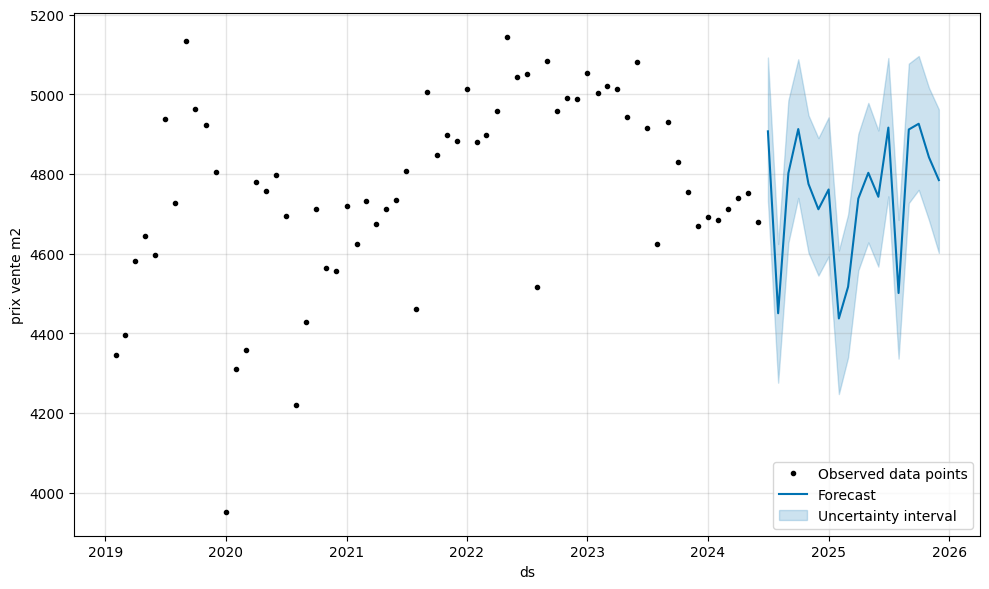

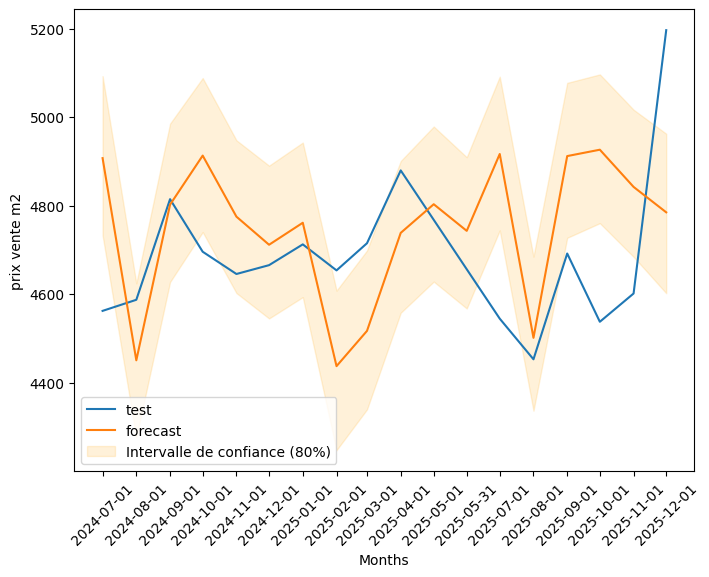

In [84]:
from prophet import Prophet
length = 18

df3 = df2.rename(columns={"date" : "ds","prix_m2_vente":"y"})
df3 = pd.merge(df3,inflation,left_index=True,right_on="date")
df3.set_index(df2.index,inplace=True)
df3.drop("date",axis=1,inplace=True)

display(df3)
print (df3.columns)

df_train = df3[:-length]
df_test = df3[-length:]


model = Prophet (yearly_seasonality=True)

model.add_regressor('inflation')
model.add_regressor('taux_livret_A')
model.add_regressor('taux_BCE')
model.add_regressor('taux_pret_20ans')

attributes = ['ds', 'y', 'inflation','taux_livret_A','taux_BCE','taux_pret_20ans']
local_frame = df_train[attributes]
display(local_frame)
model.fit (local_frame)

future = model.make_future_dataframe(periods=length,freq="MS")
print("future")
display(future)
future = df_test[attributes].copy()
display(future)

forecast = model.predict(future)
display(forecast)

model.plot(forecast, ylabel = "prix vente m2",plot_cap=True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_test['ds'],df_test["y"],label="test")
plt.plot(df_test['ds'],forecast["yhat"].iloc[-length:],label="forecast")
plt.ylabel('prix vente m2')
plt.xlabel('Months')
plt.xticks(df_test['ds'], rotation=45)

plt.fill_between(df_test['ds'], forecast['yhat_lower'].tail(length), forecast['yhat_upper'].tail(length), 
                 color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.legend()
plt.show()

forecast1 = forecast

# regressor_coefficients = {
#     'inflation': model.extra_regressors['inflation']['prior_scale'],
#     'taux livret A': model.extra_regressors['taux_livret_A']['prior_scale'],
#     'taux BCE': model.extra_regressors['taux_BCE']['prior_scale'],
#     'taux pret 20 ans': model.extra_regressors['taux_pret_20ans']['prior_scale']
# }
# plt.bar(regressor_coefficients.keys(), regressor_coefficients.values())
# plt.ylabel('Prior Scale')
# plt.title('Regressor Prior Scales')
# plt.tick_params(axis='x', rotation=45)
# plt.grid(True, alpha=0.3, axis='y')


,y,ds
date,,
2019-02-01,4346.828981,2019-02-01 00:00:00.000000000
2019-03-01,4396.564659,2019-03-01 00:00:00.000000000
2019-04-01,4582.680229,2019-04-01 00:00:00.000000000
2019-05-01,4643.971588,2019-05-01 00:00:00.000000000
2019-06-01,4596.453575,2019-06-01 00:00:00.000000000
...,...,...
2025-08-01,4452.751555,2025-08-01 00:00:00.000000000
2025-09-01,4691.698509,2025-09-01 00:00:00.000000000
2025-10-01,4537.504116,2025-10-01 00:00:00.000000000


20:33:33 - cmdstanpy - INFO - Chain [1] start processing
20:33:33 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2019-02-01
1,2019-03-01
2,2019-04-01
3,2019-05-01
4,2019-06-01
...,...
78,2025-08-01
79,2025-09-01
80,2025-10-01
81,2025-11-01


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-02-01,4551.776571,4273.001840,4645.694778,4551.776571,4551.776571,-92.912003,-92.912003,-92.912003,-92.912003,-92.912003,-92.912003,0.0,0.0,0.0,4458.864568
1,2019-03-01,4556.972019,4431.895936,4822.030570,4556.972019,4556.972019,65.537223,65.537223,65.537223,65.537223,65.537223,65.537223,0.0,0.0,0.0,4622.509242
2,2019-04-01,4562.724121,4449.059111,4839.496763,4562.724121,4562.724121,75.216400,75.216400,75.216400,75.216400,75.216400,75.216400,0.0,0.0,0.0,4637.940522
3,2019-05-01,4568.290672,4440.911326,4828.890429,4568.290672,4568.290672,76.030638,76.030638,76.030638,76.030638,76.030638,76.030638,0.0,0.0,0.0,4644.321311
4,2019-06-01,4574.042775,4425.210680,4818.167769,4574.042775,4574.042775,47.386973,47.386973,47.386973,47.386973,47.386973,47.386973,0.0,0.0,0.0,4621.429748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2025-08-01,4548.260377,4095.175271,4500.811296,4517.039974,4582.781037,-250.981709,-250.981709,-250.981709,-250.981709,-250.981709,-250.981709,0.0,0.0,0.0,4297.278669
79,2025-09-01,4535.711631,4454.482502,4858.968656,4500.153552,4573.508734,126.337552,126.337552,126.337552,126.337552,126.337552,126.337552,0.0,0.0,0.0,4662.049183
80,2025-10-01,4523.567682,4451.571821,4846.376275,4485.448414,4565.359580,129.439031,129.439031,129.439031,129.439031,129.439031,129.439031,0.0,0.0,0.0,4653.006713
81,2025-11-01,4511.018935,4355.015373,4753.523454,4468.626214,4556.963389,41.976862,41.976862,41.976862,41.976862,41.976862,41.976862,0.0,0.0,0.0,4552.995797


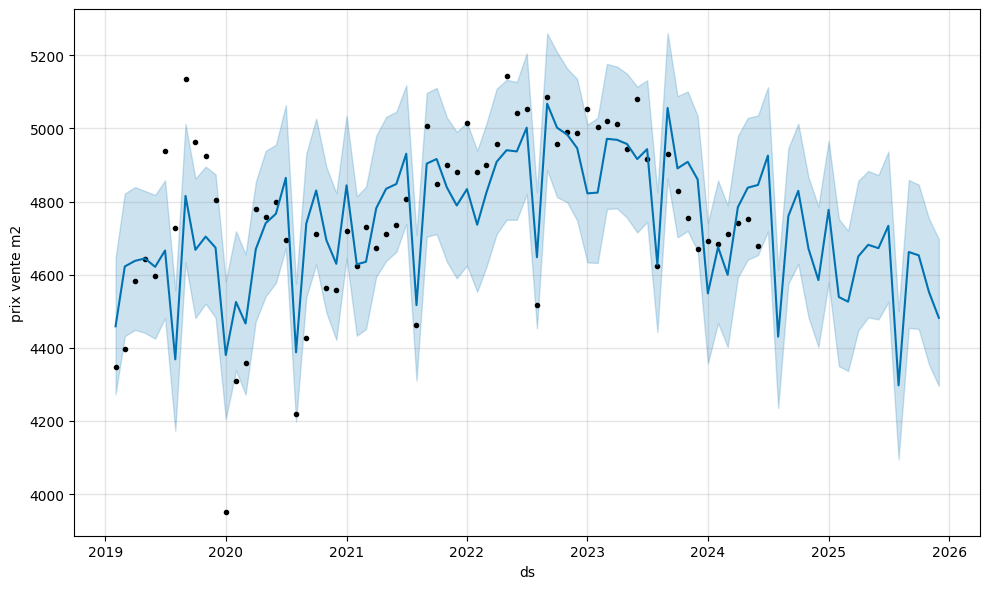

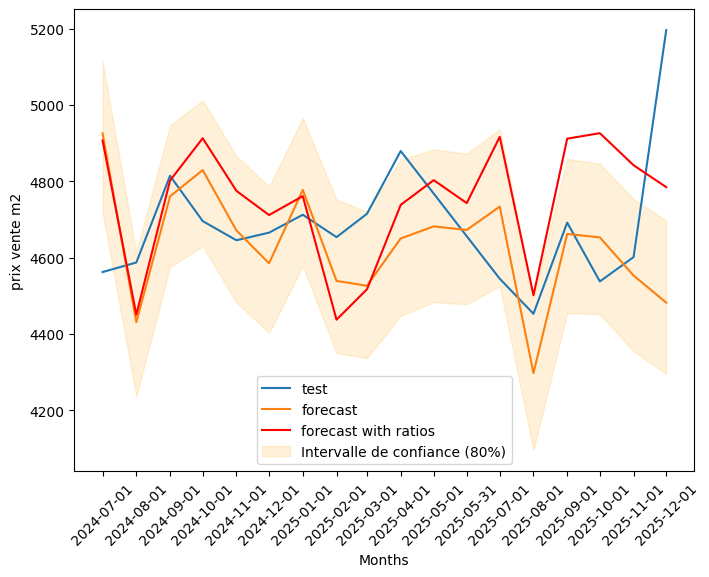

In [87]:
from prophet import Prophet
length = 18
df3 = df2.rename(columns={"date" : "ds","prix_m2_vente":"y"})
display(df3)
df_train = df3[:-length]
df_test = df3[-length:]

model = Prophet ()
model.fit (df_train)

future = model.make_future_dataframe(periods=length,freq="MS")
display(future)

forecast = model.predict(future)
display(forecast)

model.plot(forecast, ylabel = "prix vente m2")

plt.show()

plt.figure(figsize=(8, 6))
plt.plot(df_test['ds'],df_test["y"],label="test")
plt.plot(df_test['ds'],forecast["yhat"].iloc[-length:],label="forecast")
plt.plot(df_test['ds'],forecast1["yhat"].iloc[-length:],label="forecast with ratios",color="red")

plt.ylabel('prix vente m2')
plt.xlabel('Months')
plt.xticks(df_test['ds'], rotation=45)

plt.fill_between(df_test['ds'], forecast['yhat_lower'].tail(length), forecast['yhat_upper'].tail(length), 
                 color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.legend()
plt.show()